In [27]:
import os
import re
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pandas import DataFrame, concat

import torch
from torchinfo import summary
from torch.utils.data import DataLoader
import torch.nn.functional as F

from models.vae import VAE
from models.rnn import RNN
from models.dnn_trainer import DNNTrainer

In [15]:
# 5 levels of attack intensity: levels 5, 6, 7, 8, 9
attack_intensity = 5
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [16]:
seed = 13
# seed = 23
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# DNN Data Generation

In [17]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{attack_intensity}')
Z, RES = dict(), dict()
for filename in tqdm(os.listdir(ATTACK_DATA_PATH), desc='Reading data ... '):
    fname = os.path.join(ATTACK_DATA_PATH, filename)
    data = loadmat(fname)
    att_type = int(re.findall(r'\d+', filename)[0])
    Z[att_type] = data['Z']
    RES[att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']


Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


In [19]:
latent_dim = 118
hidden_size = 100
num_layers = 2
batch_size = 16
rnn_window = 10
samples = 30

In [20]:
vae = VAE(latent_dim).to(device)
vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'vae.pt')))

rnn = RNN(input_dims=rnn_window * latent_dim,
          outputdims=latent_dim,
          hidden_size=hidden_size,
          num_layers=num_layers)
rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'rnn.pt')))

<All keys matched successfully>

In [26]:
vae.eval()
rnn.eval()
Res = dict()
for k, v in tqdm(Z.items(), desc="Generating residuals ... "):
    # state estimation residual
    r1 = torch.tensor(RES[k], dtype=torch.float32)
    
    z = torch.tensor(v, dtype=torch.float32).to(device)
    R = []
    for _ in range(samples):
        # VAE residuals
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()
        
        # rnn prediction residual
        s_t = vae.encoder(z)
        s_t = series_to_supervised(s_t.cpu().detach().numpy(), n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32)
        s_tt = rnn(s_t)
        z_rnn = vae.decoder(s_tt)
        # r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        # R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
        r0 = (z_rnn - z[rnn_window:]).detach().cpu()
        r3 = torch.zeros(r1.size(), dtype=torch.float32)
        index = torch.tensor(list(range(rnn_window, len(r1))))
        r3.index_add_(0, index, r0)
        R.append(torch.stack([r1,r2,r3], dim=1))
    Res[k] = torch.stack(R, dim=1)

Generating residuals ... : 100%|██████████| 4/4 [02:41<00:00, 40.28s/it]


In [28]:
def get_data(train_size):
    X, y = dict(), dict()
    trainX, testX = [], []
    trainY, testY = [], []
    for k, v in Res.items():
        y_i = k * torch.ones((v.shape[0]), dtype=torch.long)
        trainX.append(v[:train_size])
        testX.append(v[train_size:])
        trainY.append(y_i[:train_size])
        testY.append(y_i[train_size:])
    X['train'] = torch.cat(trainX, dim=0)
    X['test'] = torch.cat(testX, dim=0)
    y['train'] = F.one_hot(torch.cat(trainY, dim=0)).float()
    y['test'] = F.one_hot(torch.cat(testY, dim=0)).float()
    return X, y

In [29]:
class ResidualData():
    def __init__(self, X, y):
        self.X, self.y = X, y
    
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train DNN

In [30]:
batch_size = 16
epochs = 1000
train_size = int(len(Res[0]) * 0.85)
epochs = 1000
lr = 1e-1
scheduler = True
es_patience = 10

In [31]:
X, y = get_data(train_size)
training = ResidualData(X['train'], y['train'])
test = ResidualData(X['test'], y['test'])
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test)

In [32]:
X['train'].shape

torch.Size([11176, 30, 3, 358])

In [34]:
trainer = DNNTrainer(lr=lr, lr_scheduler=scheduler,
                     es_patience=es_patience, seed=seed)

Device:  cpu


In [35]:
summary(trainer.dnn, (1, 30, 3, 358))

Layer (type:depth-idx)                   Output Shape              Param #
DNN                                      [1, 4]                    --
├─Linear: 1-1                            [1, 30, 3, 128]           45,952
├─Linear: 1-2                            [1, 30, 3, 64]            8,256
├─Linear: 1-3                            [1, 30, 3, 32]            2,080
├─Linear: 1-4                            [1, 30, 64]               6,208
├─Linear: 1-5                            [1, 30, 16]               1,040
├─Linear: 1-6                            [1, 30, 4]                68
Total params: 63,604
Trainable params: 63,604
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.06
Input size (MB): 0.13
Forward/backward pass size (MB): 0.18
Params size (MB): 0.25
Estimated Total Size (MB): 0.56

In [36]:
dnn, loss, val_loss, acc, val_acc = trainer.train(train_dl=train_dl,
                                                  val_dl=test_dl,
                                                  epochs=epochs)

Epoch 1/1000: [Loss: 1.4808], [Accuracy: 0.2440], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
Validation loss decreased (inf --> 1.493668).  Saving model ...
Epoch 2/1000: [Loss: 1.4936], [Accuracy: 0.2499], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
Validation loss decreased (1.493668 --> 1.493668).  Saving model ...
Epoch 3/1000: [Loss: 1.4958], [Accuracy: 0.2478], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
Validation loss decreased (1.493668 --> 1.493668).  Saving model ...
Epoch 4/1000: [Loss: 1.4909], [Accuracy: 0.2526], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
Validation loss decreased (1.493668 --> 1.493668).  Saving model ...
Epoch 5/1000: [Loss: 1.4949], [Accuracy: 0.2484], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
EarlyStopping counter: 1 out of 10
Epoch 6/1000: [Loss: 1.4998], [Accuracy: 0.2431], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
EarlyStopping counter: 2 out of 10
Epoch 7/1000: [Loss: 1.4925], [Accuracy: 0.2508], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
EarlySto

In [37]:
def plot_learning(loss, val_loss):
    fig, axs = plt.subplots(figsize=(10,8))
    axs.plot(loss, color='r', label='Training')
    axs.plot(val_loss, color='b', label='Validation')
    axs.set_title('Training vs. Validation Loss')
    plt.legend()
    # plt.savefig('acc.pdf', format='pdf', dpi=1200)
    plt.show()

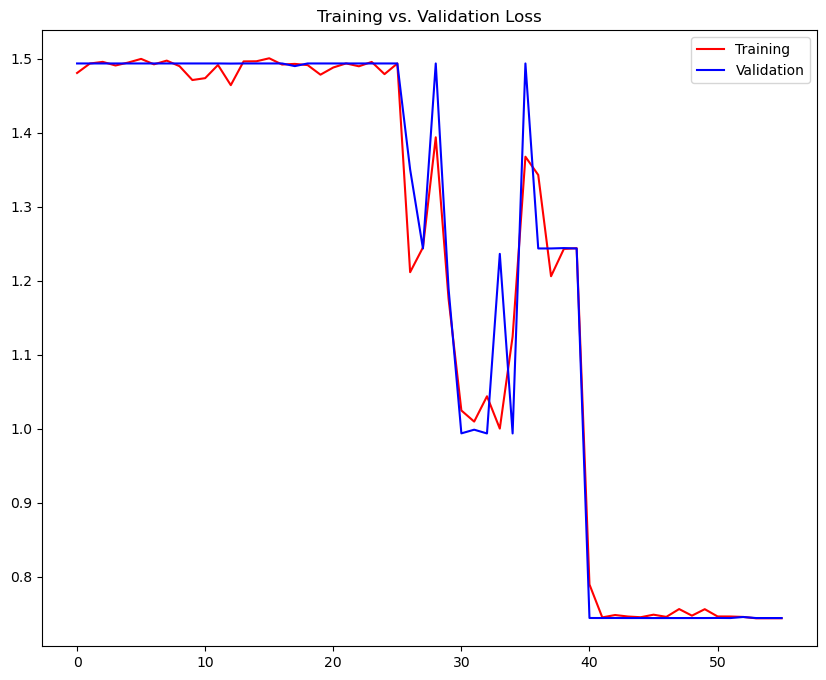

In [38]:
plot_learning(loss, val_loss)

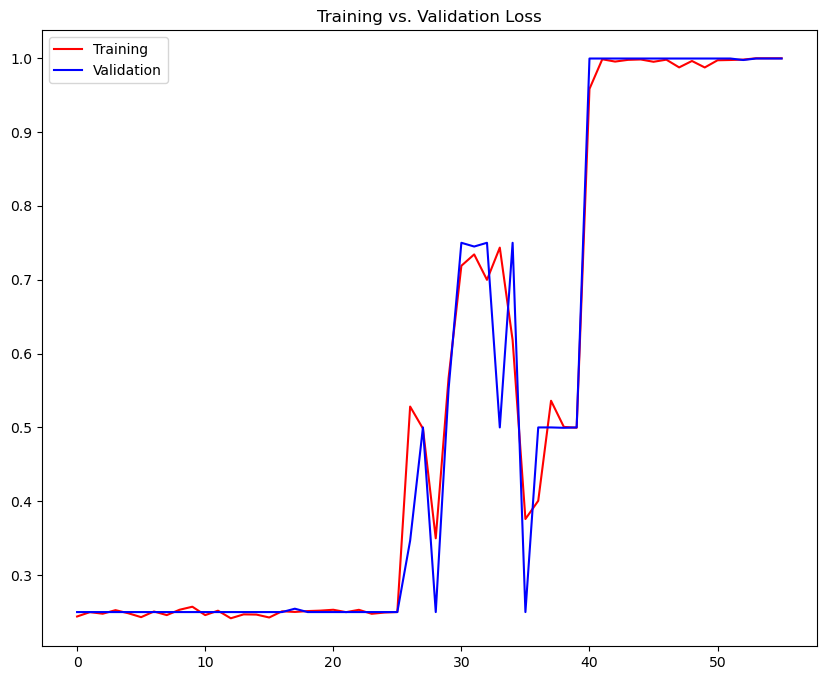

In [39]:
plot_learning(acc, val_acc)

In [40]:
dnn.eval()
preds = dnn(X['test'].to(device))
preds

tensor([[9.9991e-01, 2.5543e-16, 7.1781e-19, 8.5218e-05],
        [9.9999e-01, 3.1852e-18, 1.5333e-20, 8.0427e-06],
        [9.9999e-01, 3.6056e-18, 2.7803e-20, 5.2768e-06],
        ...,
        [2.2968e-06, 5.3401e-06, 1.0491e-11, 9.9999e-01],
        [5.8431e-06, 3.1088e-06, 8.7552e-12, 9.9999e-01],
        [3.9364e-05, 4.4737e-07, 1.7598e-12, 9.9996e-01]],
       grad_fn=<SqueezeBackward1>)

In [41]:
dnn.eval()
pred_train = dnn(X['train'].to(device))
pred_train

tensor([[1.0000e+00, 1.1518e-17, 1.6145e-19, 3.3852e-06],
        [9.9999e-01, 9.8404e-17, 1.5714e-18, 8.5630e-06],
        [1.0000e+00, 2.1316e-17, 3.1197e-19, 4.3705e-06],
        ...,
        [1.9570e-06, 3.7120e-06, 5.5755e-12, 9.9999e-01],
        [7.0405e-06, 1.3404e-06, 2.8811e-12, 9.9999e-01],
        [4.1465e-07, 2.1188e-05, 2.1517e-11, 9.9998e-01]],
       grad_fn=<SqueezeBackward1>)

In [42]:
trainer.accuracy(preds, y['test'])

tensor(0.9995)

In [43]:
trainer.accuracy(pred_train, y['train'])

tensor(0.9998)

In [ ]:
trainer.accuracy(pred_train, y['train'])